# Custom model with activation plotting
(Note that this is a simplified version with a small net)


In [ ]:
USING_COLAB = True

In [ ]:
# Fix randomness and hide warnings
seed = 42
input_shape = (96, 96, 3)

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import numpy as np
import math
np.random.seed(seed)
import pandas as pd

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

l2_reg = 0.001

tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

In [ ]:
if USING_COLAB :
    from google.colab import drive
    drive.mount('/gdrive')
    from google.colab import drive
    %cd /gdrive/My Drive/[2023-2024] AN2DL/Homework1
    #    %cd /gdrive/My Drive/[2023-2024] AN2DL/Fede/Challenge1/Data/Augmented_Experimental

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2023-2024] AN2DL/Homework1


# Model creation
This function creates a model where we can specify both the amount of filters per layer and the kernel sizes. Whenever the filter amount changes, we also insert a pooling layer and create a shortcut with a 1D convolution to match the sizes.

In [ ]:
convolution_filters = [3,9,27,27,27,27]#,32,32,32]
kernel_sizes = [7,7,7,7,7,7,7,7,7,7,7,7,7,7,7]
kernel_sizes_2 = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]
kernel_sizes_3 = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
layerLocs = [] # Used later

def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape)

    x = tfkl.Rescaling(1./255)(input_layer)

    x = tf.keras.Sequential([
        tfkl.RandomBrightness(0.3, value_range=(0,1)),
        tfkl.RandomTranslation(0.02,0.02),
        tfkl.RandomContrast(0.1),
        tfkl.RandomZoom(0.02),
        tfkl.RandomRotation(0.02),
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical")
    ], name='preprocessing')(x)

    prev = 3 # Useful in case we need to do stuff when the filter size changes
    biforcationStart = x

    idx = 2

    # CONVOLUTIONAL FILTERS
    for i in range(len(convolution_filters)) :
        # Create a shortcut if we change convolution size
        if prev != convolution_filters[i] and prev != None :
            biforcationStart = tfkl.Conv2D(filters=prev * 3, kernel_size=1, padding='same', activation='swish')(biforcationStart)
            idx += 1

            x = tfkl.Add()([x,biforcationStart])
            idx += 1

            x = tfkl.MaxPooling2D()(x)
            idx += 1

            biforcationStart = x

        ###
        x1 = tfkl.Conv2D(filters=convolution_filters[i], kernel_size=1, padding='same', activation='swish')(x)
        idx += 1
        x1 = tfkl.Conv2D(filters=convolution_filters[i], kernel_size=kernel_sizes[i], padding='same', activation='swish')(x1)
        layerLocs.append(idx)
        idx += 1
        ###

        ###
        x2 = tfkl.Conv2D(filters=convolution_filters[i], kernel_size=1, padding='same', activation='swish')(x)
        idx += 1
        x2 = tfkl.Conv2D(filters=convolution_filters[i], kernel_size=kernel_sizes_2[i], padding='same', activation='swish')(x2)
        layerLocs.append(idx)
        idx += 1
        ###

        ###
        x3 = tfkl.Conv2D(filters=convolution_filters[i], kernel_size=1, padding='same', activation='swish')(x)
        idx += 1
        x3 = tfkl.Conv2D(filters=convolution_filters[i], kernel_size=kernel_sizes_3[i], padding='same', activation='swish')(x3)
        layerLocs.append(idx)
        idx += 1
        ###

        x = tfkl.Concatenate(
        axis=-1)([x1, x2, x3])
        idx += 1
        x = tfkl.BatchNormalization()(x)
        idx += 1

        #if prev != convolution_filters[i] and prev != None :
        #    biforcationStart = x

        if prev == None:
            biforcationStart = x # Set for the first time only


        #x = tfkl.BatchNormalization()(x)
        #idx += 1

        prev = convolution_filters[i]

    # One last time
    biforcationStart = tfkl.Conv2D(filters=prev * 3, kernel_size=1, padding='same', activation='swish')(biforcationStart)
    idx += 1

    x = tfkl.Add()([x,biforcationStart])
    idx += 1

    x = tfkl.MaxPooling2D()(x)
    idx += 1

    x = tfkl.Conv2D(filters=convolution_filters[-1], kernel_size=1, padding='same', activation='swish')(x)
    x = tfkl.MaxPooling2D()(x)
    x = tfkl.GlobalAveragePooling2D()(x)

    output_layer = tfkl.Dense(units=1, activation='sigmoid')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(),
    optimizer=tfk.optimizers.AdamW(),
    metrics=['accuracy'])

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['rescaling[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 3)            12        ['preprocessing[0][0]']       
                                                                                              

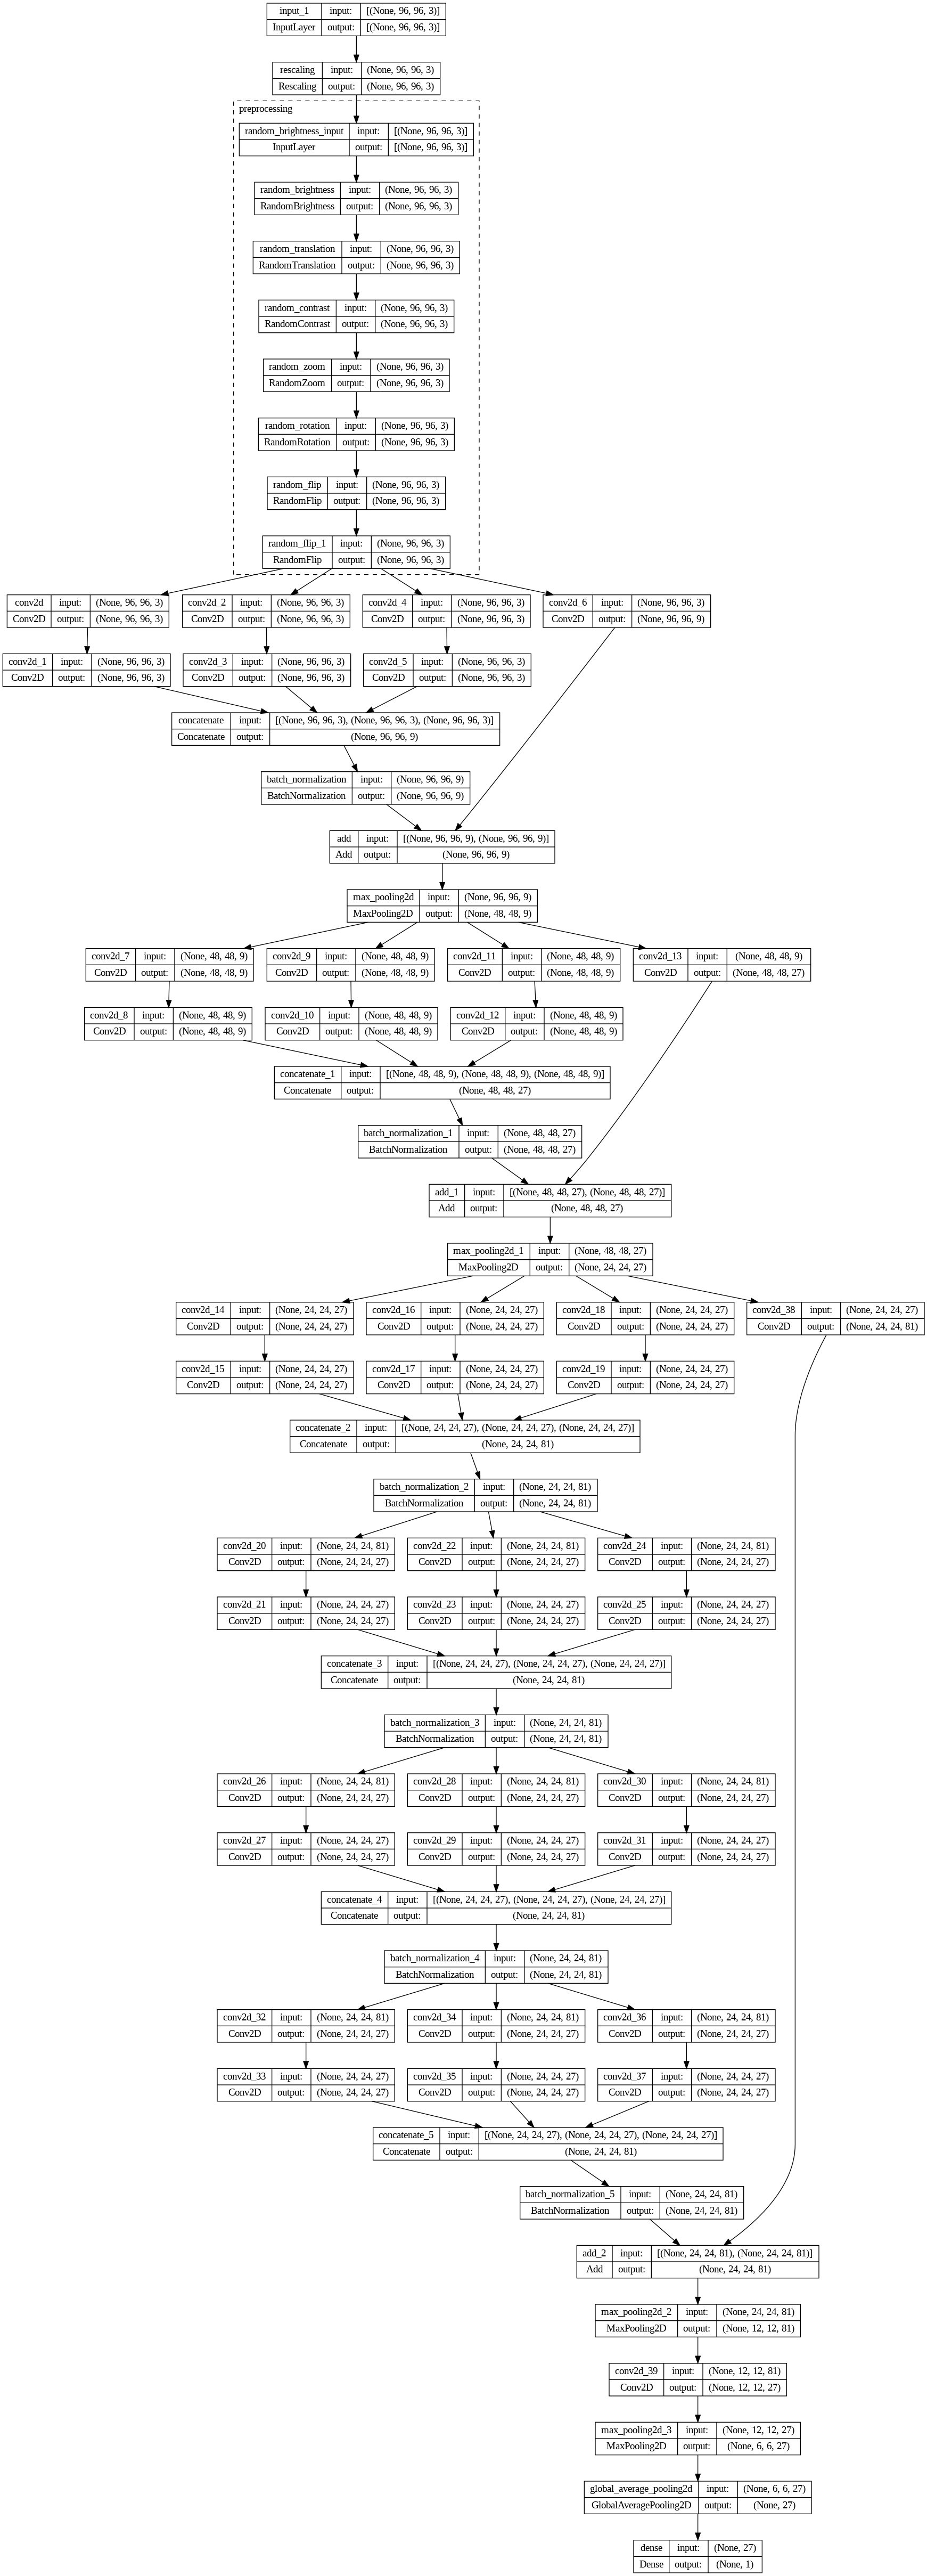

In [ ]:
model = build_model((96, 96, 3))

model.summary()
tfk.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Train

In [ ]:
if USING_COLAB:
    dir = '/gdrive/My Drive/[2023-2024] AN2DL/Fede/Challenge 1/Data/'
else:
    train_dir = 'Data/Augmented_Experimental_Shrinked/Train'
    val_dir = 'Data/Augmented_Experimental_Shrinked/Validation'

data_train = np.load(dir + 'augmented_train_mix.npz', allow_pickle=True)
data_val = np.load(dir + 'val_unbalanced_mix.npz', allow_pickle=True)

X_train, y_train = data_train['data'], data_train['labels']
X_val, y_val = data_val['data'], data_val['labels']

In [ ]:
#with strategy.scope():
history = model.fit(
    X_train, y_train,
    epochs = 1000,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    verbose=1
  ).history

Epoch 1/1000
625/625 [==============================] - 60s 49ms/step - loss: 0.6412 - accuracy: 0.6324 - val_loss: 0.6786 - val_accuracy: 0.6064
Epoch 2/1000
625/625 [==============================] - 33s 53ms/step - loss: 0.5700 - accuracy: 0.7067 - val_loss: 0.6667 - val_accuracy: 0.6194
Epoch 3/1000
625/625 [==============================] - 40s 64ms/step - loss: 0.5223 - accuracy: 0.7432 - val_loss: 0.7957 - val_accuracy: 0.6693
Epoch 4/1000
625/625 [==============================] - 31s 50ms/step - loss: 0.4759 - accuracy: 0.7708 - val_loss: 0.5201 - val_accuracy: 0.7383
Epoch 5/1000
625/625 [==============================] - 29s 47ms/step - loss: 0.4327 - accuracy: 0.7999 - val_loss: 0.5038 - val_accuracy: 0.7572
Epoch 6/1000
625/625 [==============================] - 30s 48ms/step - loss: 0.3995 - accuracy: 0.8173 - val_loss: 0.5856 - val_accuracy: 0.7592
Epoch 7/1000
625/625 [==============================] - 30s 48ms/step - loss: 0.3744 - accuracy: 0.8350 - val_loss: 0.4300 -

In [ ]:
print("Max. val accuracy: ",np.max(history['val_accuracy']))

Max. val accuracy:  0.872127890586853


In [ ]:
# We need to save the weights when training on the home PC because it runs TF2.15 and models are incompatible with TF2.14

#if USING_COLAB:
#     model.save_model('SavedModels/SN8_')
#else:
#    model.save_weights('SavedModels/SN8_')

# Inspect results

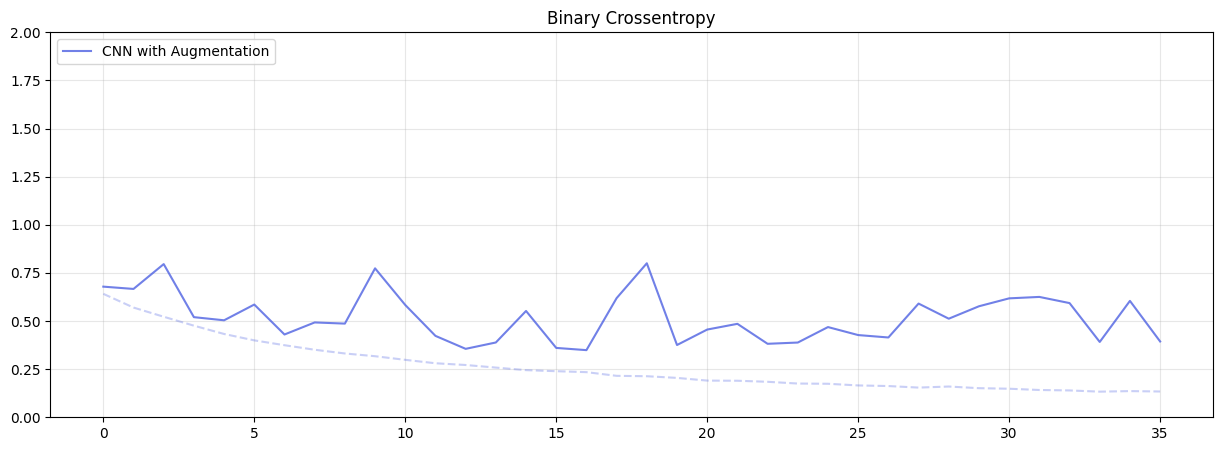

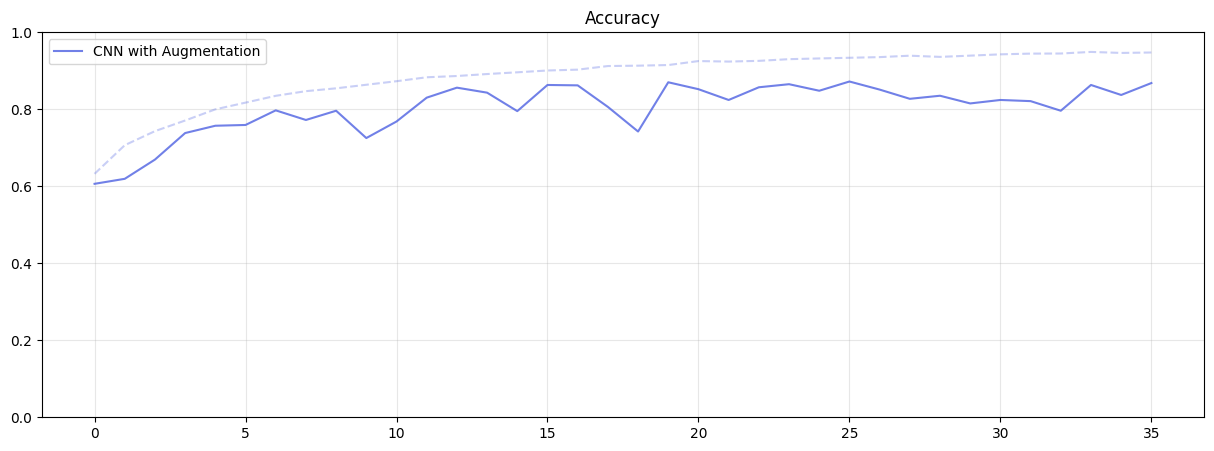

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)
plt.ylim(0,2)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.ylim(0,1)

plt.show()

## Activation inspection
Inspect automatically only the activations (not the weights) due to problems in ordering them in subplots; an example image for the weights is in the report.

In [ ]:
num_images = 200

import random

data = np.load('clean_data.npz', allow_pickle=True)
imgs, labels_str = data["data"], (data["labels"] == "unhealthy").astype(int)

images_idxs = labels_str.shape[0]

images_idxs =  random.sample(range(images_idxs), num_images)

imgs = imgs[images_idxs, :, :, :]
labels_str = labels_str[images_idxs]

imgs = imgs[ : num_images, :, :, :]
labels_str = labels_str[ : num_images]

7/7 [==============================] - 1s 12ms/step


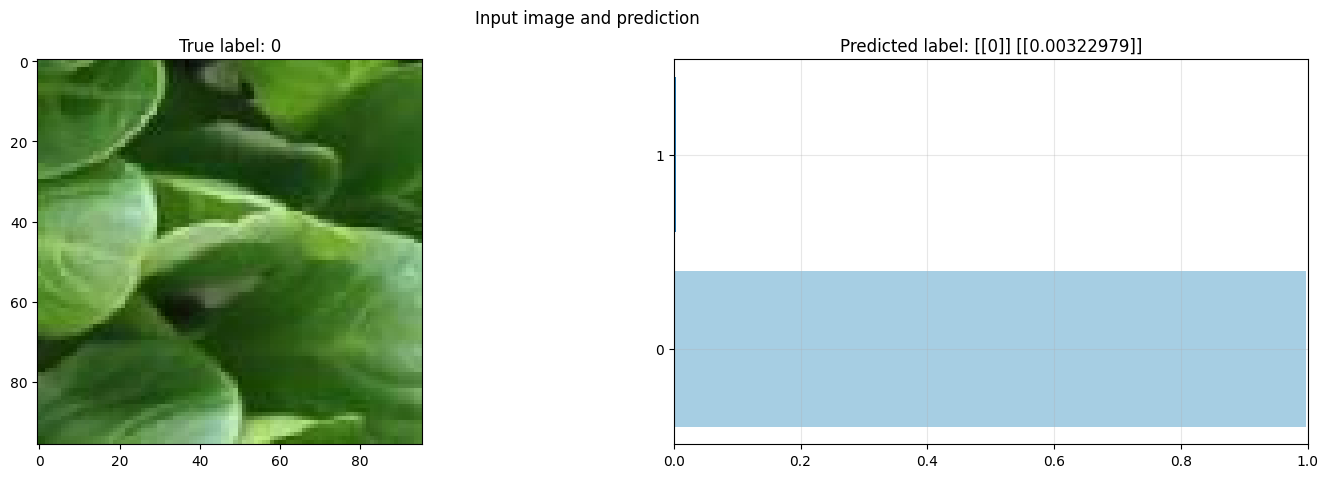

<Figure size 640x480 with 0 Axes>

In [ ]:
# Extract activations from the first convolutional layer for a subset of test images

activations = []
convs = []
for i in range(layerLocs.__len__()) :
    temp = tfk.Model(inputs=model.input, outputs=model.layers[layerLocs[i]].output)
    convs.append(temp.layers[-1])
    activations.append(temp.predict(imgs[0:num_images]))

# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(imgs[image]/255, cmap='gray')
ax1.set_title('True label: ' + str(labels_str[image]))
prediction = model.predict(np.expand_dims(imgs[image], axis=0), verbose=0)

ax2.barh(list(np.unique(labels_str).astype('str')), list([1-prediction[0][0], prediction[0][0]]), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + str((prediction > 0.5).astype(int)) + " " + str(prediction))
ax2.grid(alpha=0.3)
ax2.set_xlim([0,1])

fig.suptitle('Input image and prediction')

plt.show()
plt.savefig("input_image.png")

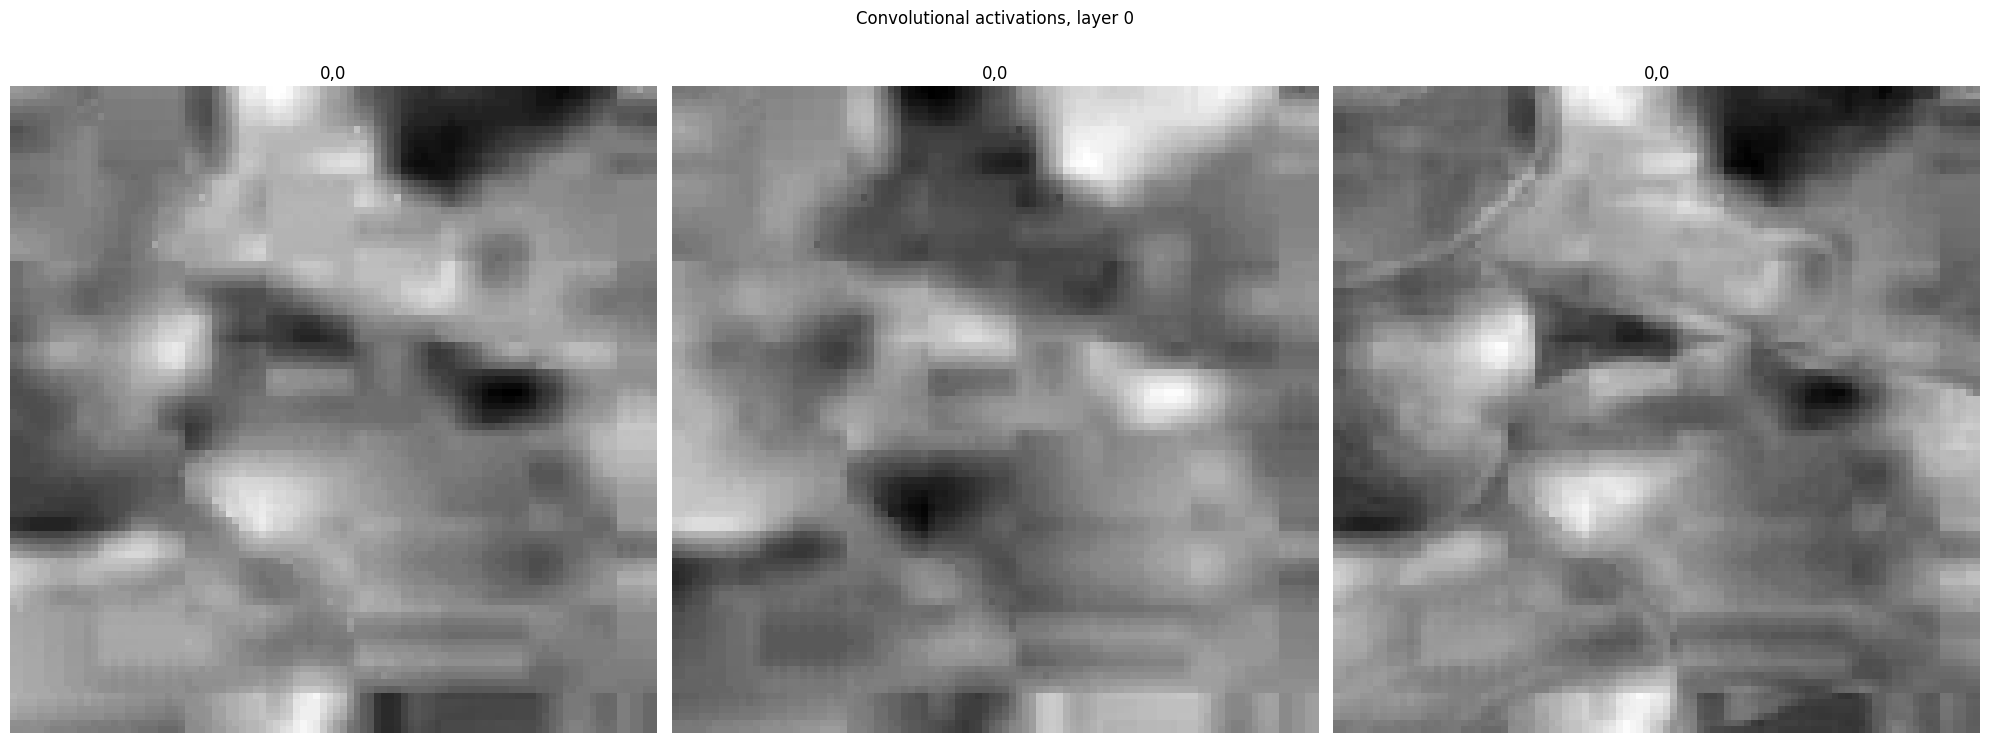

<Figure size 640x480 with 0 Axes>

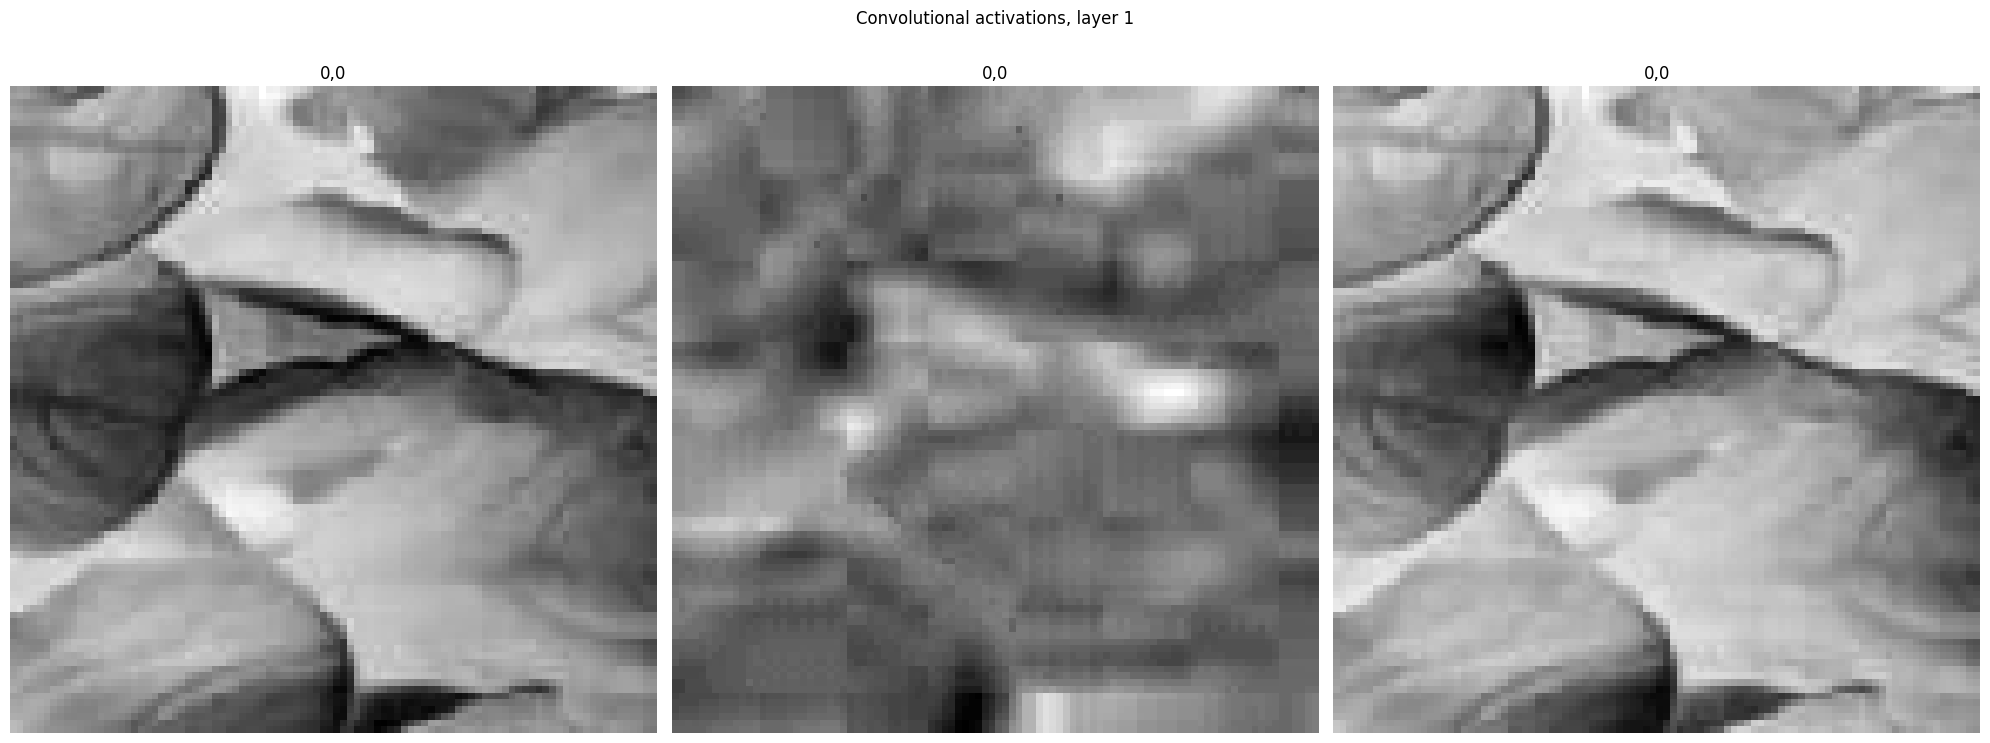

<Figure size 640x480 with 0 Axes>

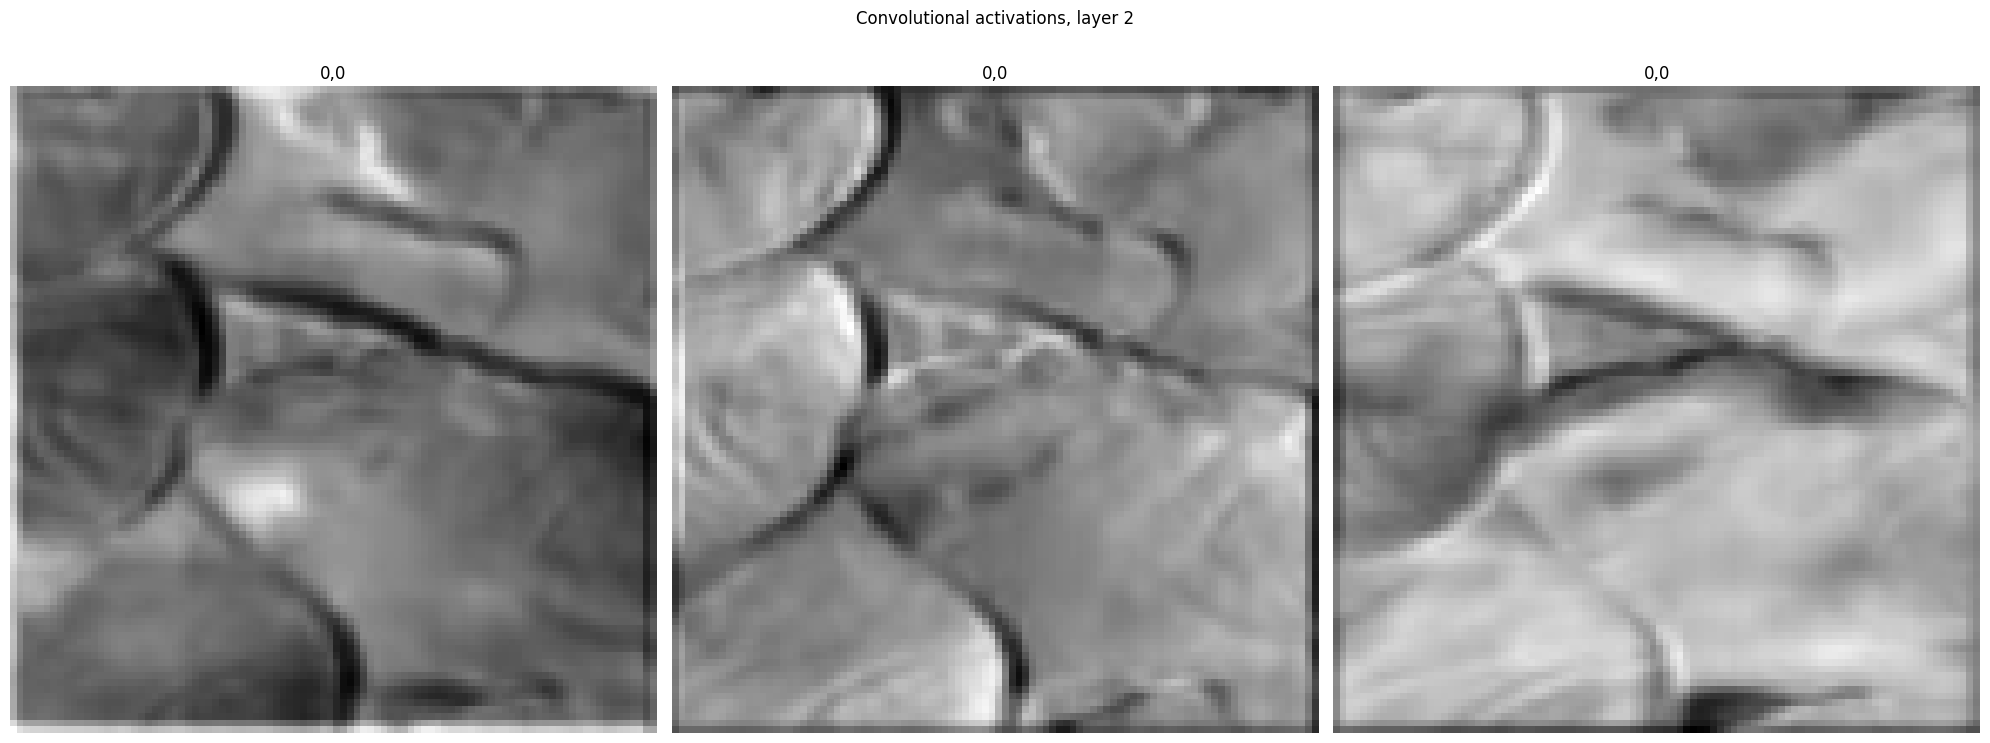

<Figure size 640x480 with 0 Axes>

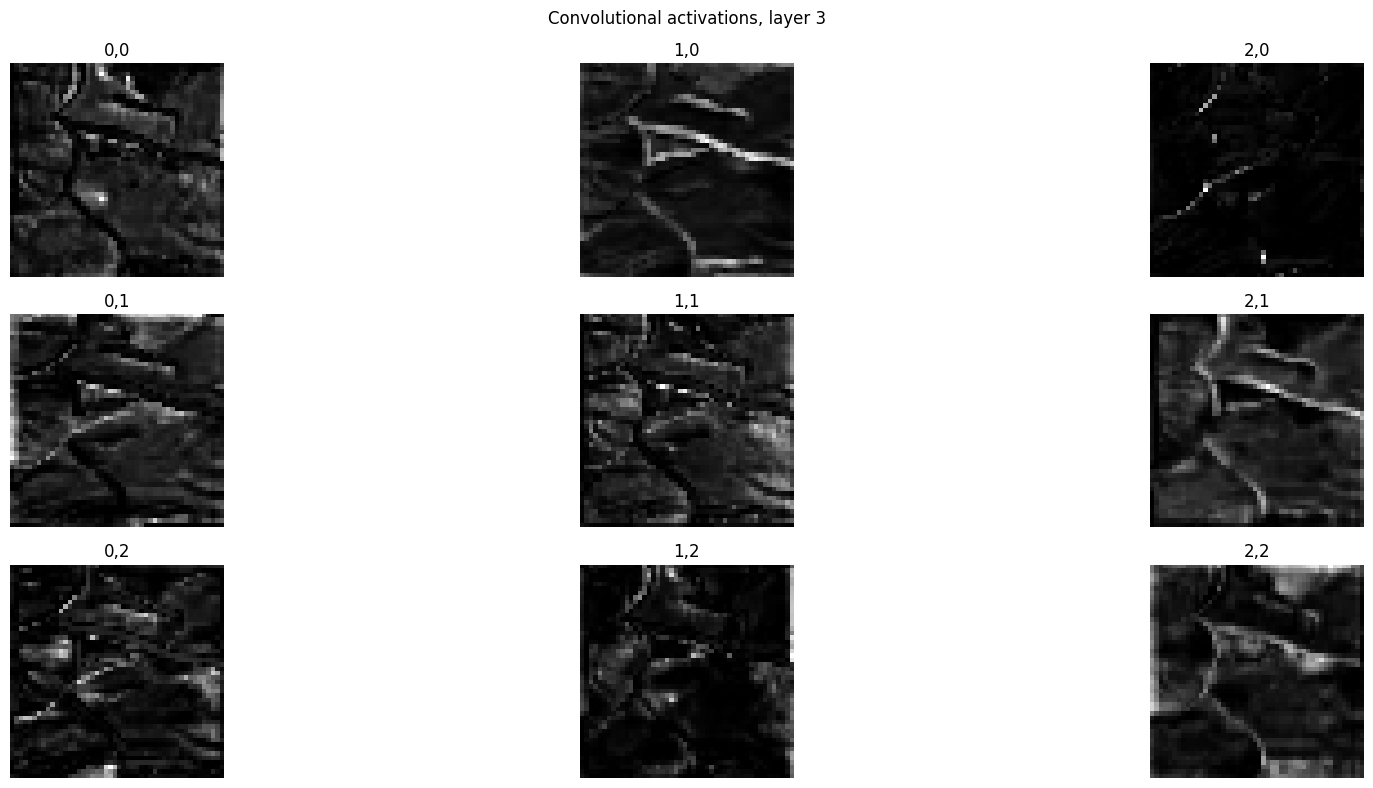

<Figure size 640x480 with 0 Axes>

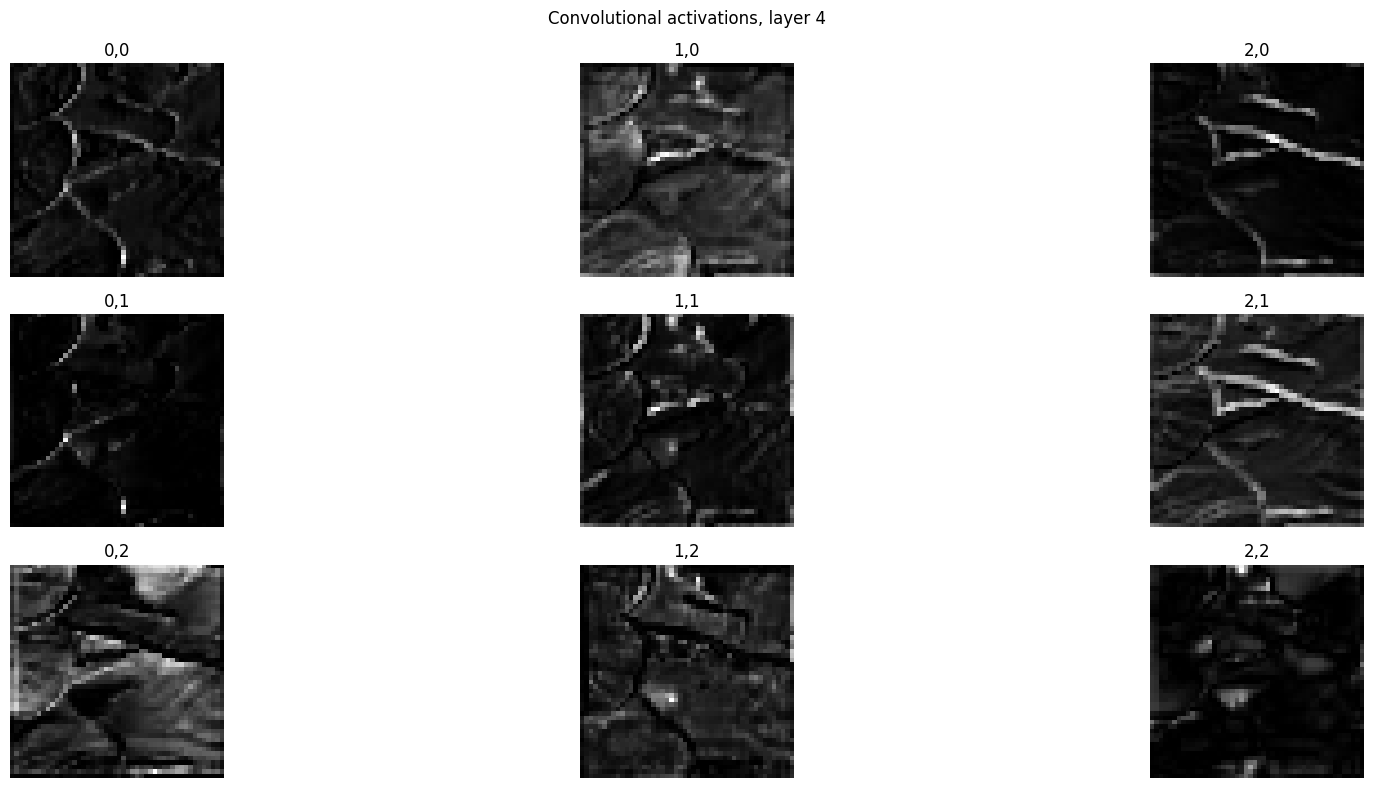

<Figure size 640x480 with 0 Axes>

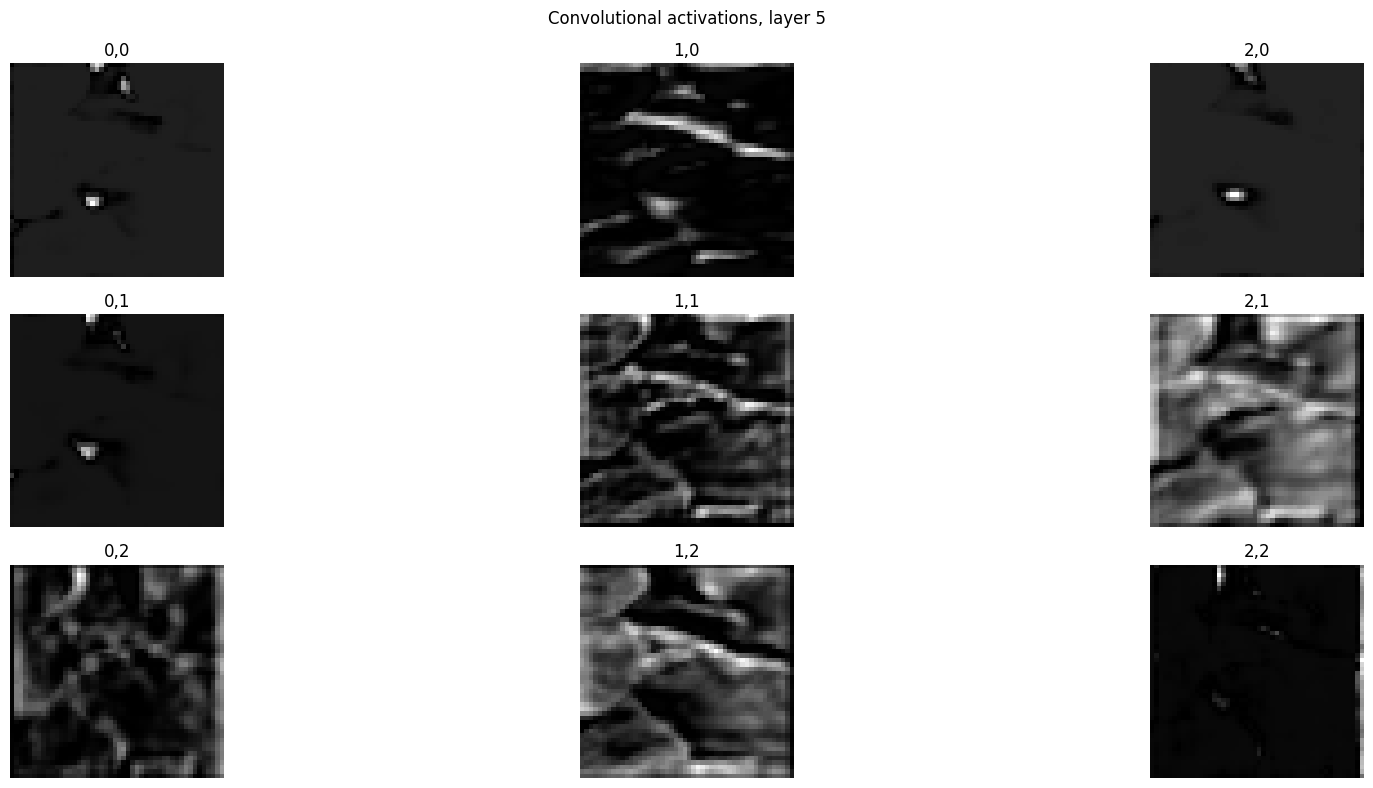

<Figure size 640x480 with 0 Axes>

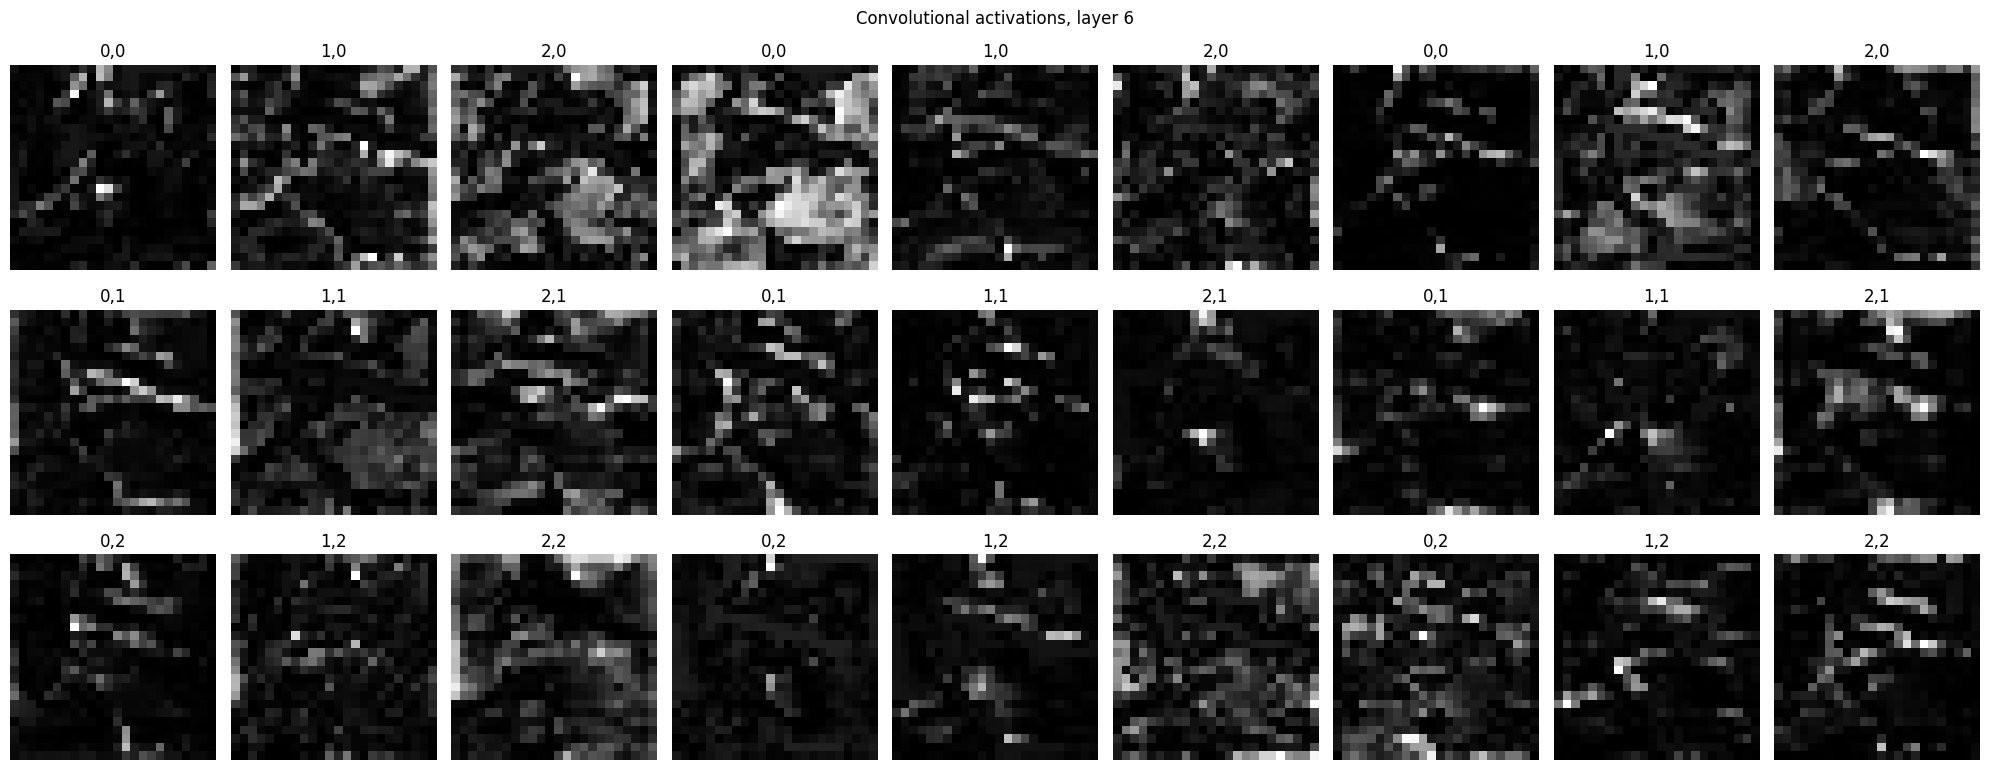

<Figure size 640x480 with 0 Axes>

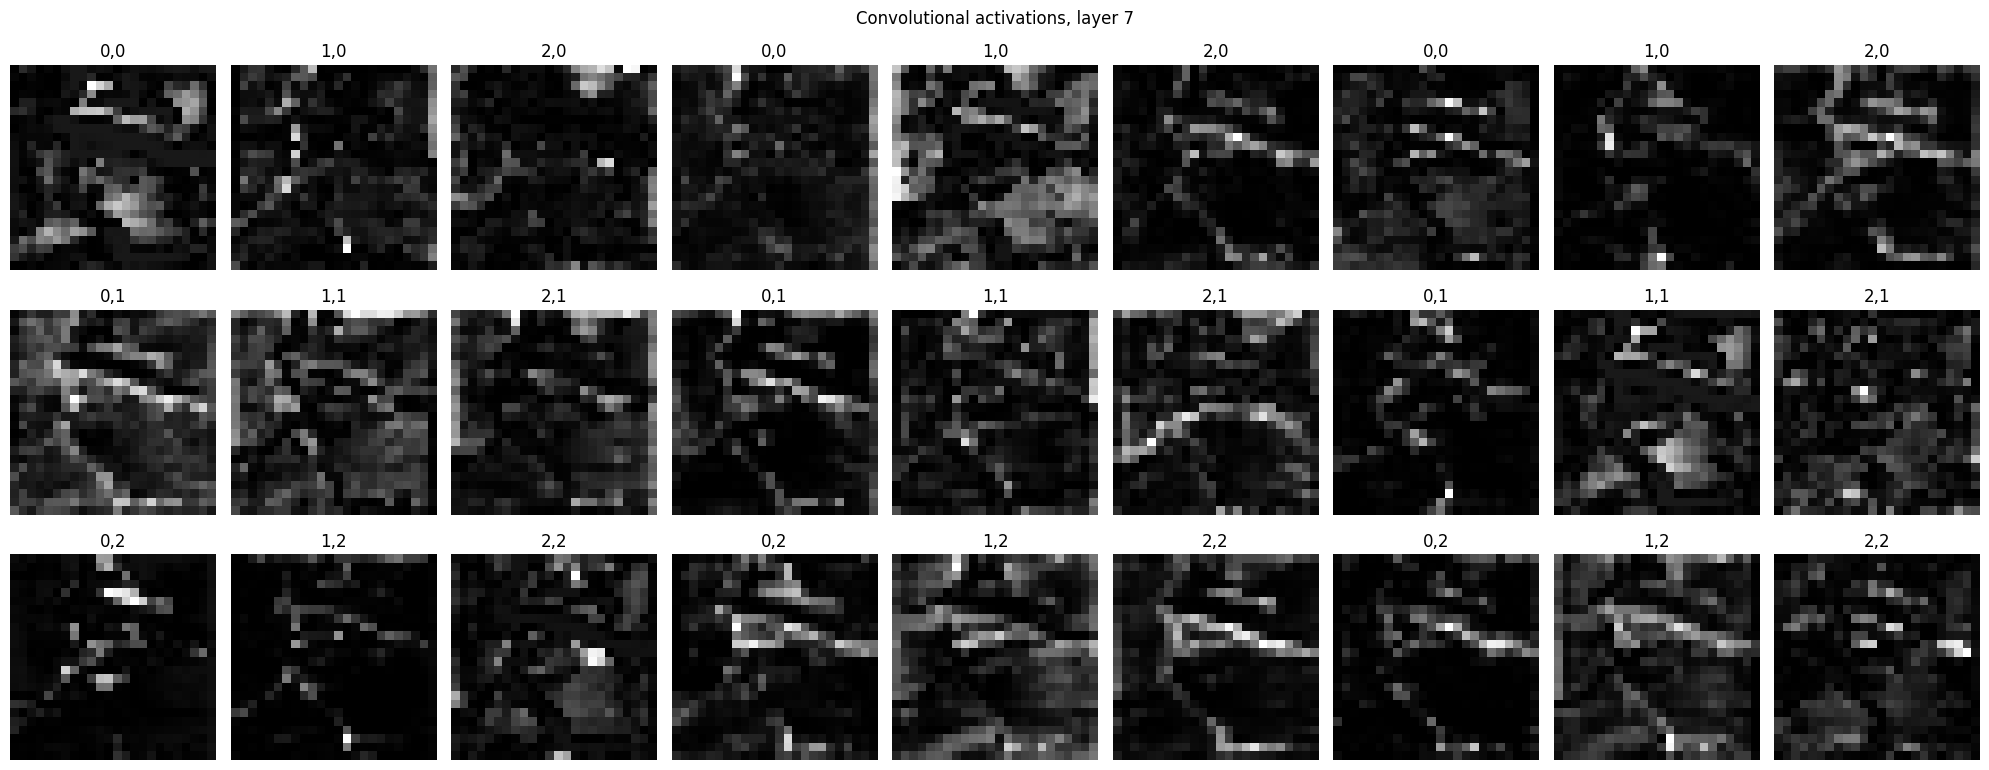

<Figure size 640x480 with 0 Axes>

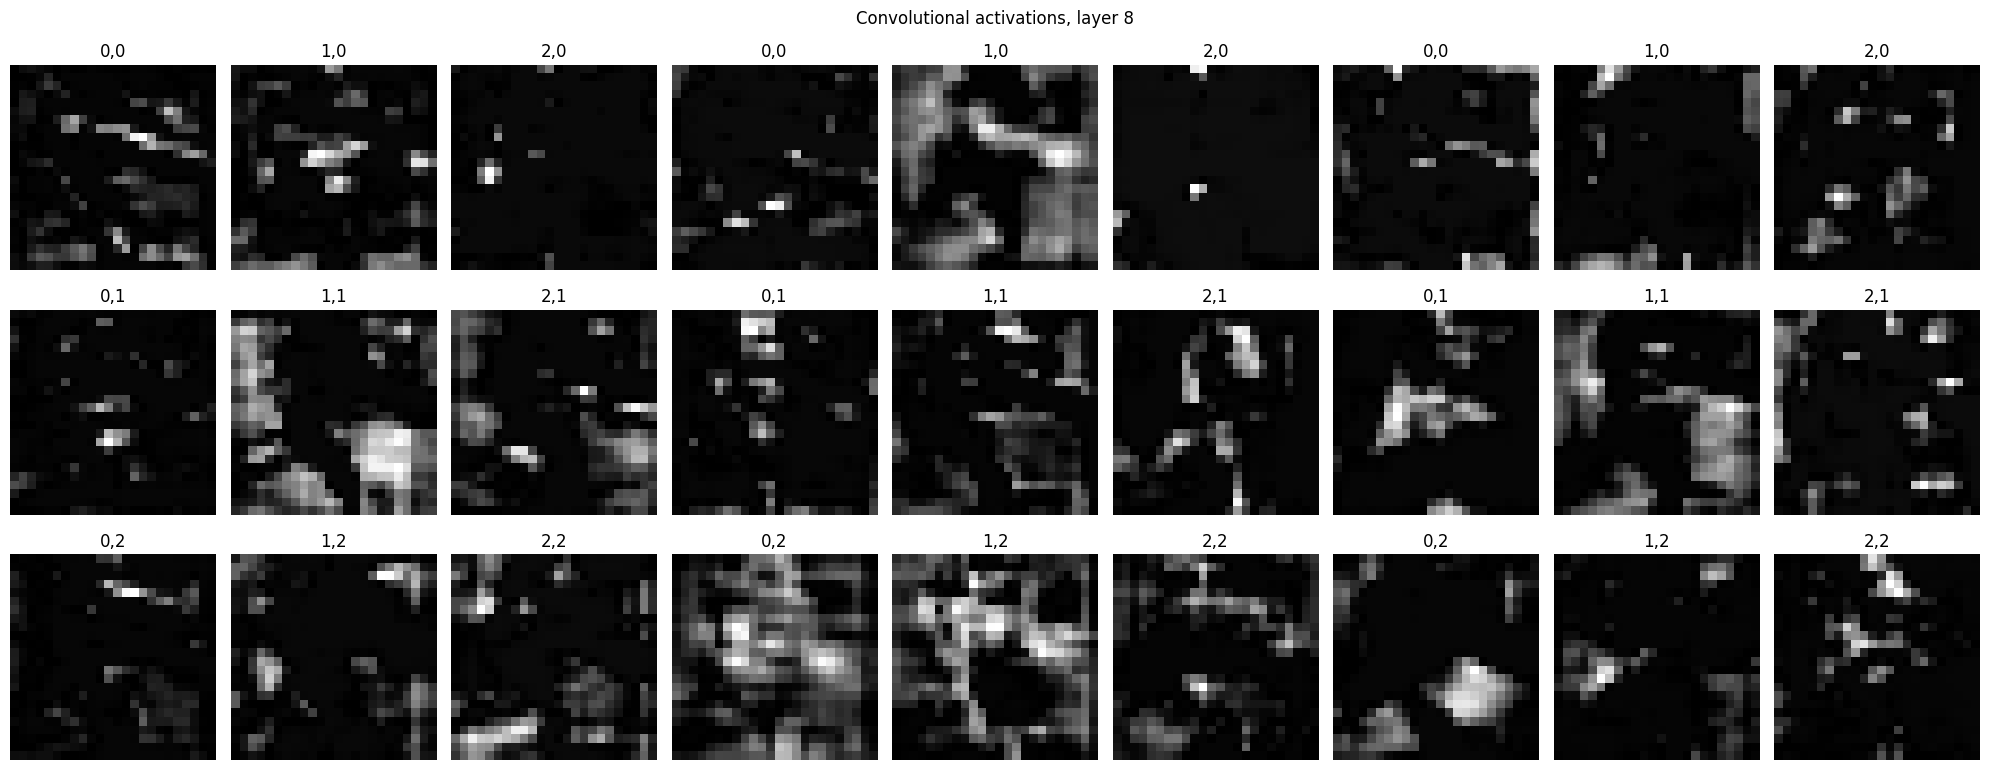

<Figure size 640x480 with 0 Axes>

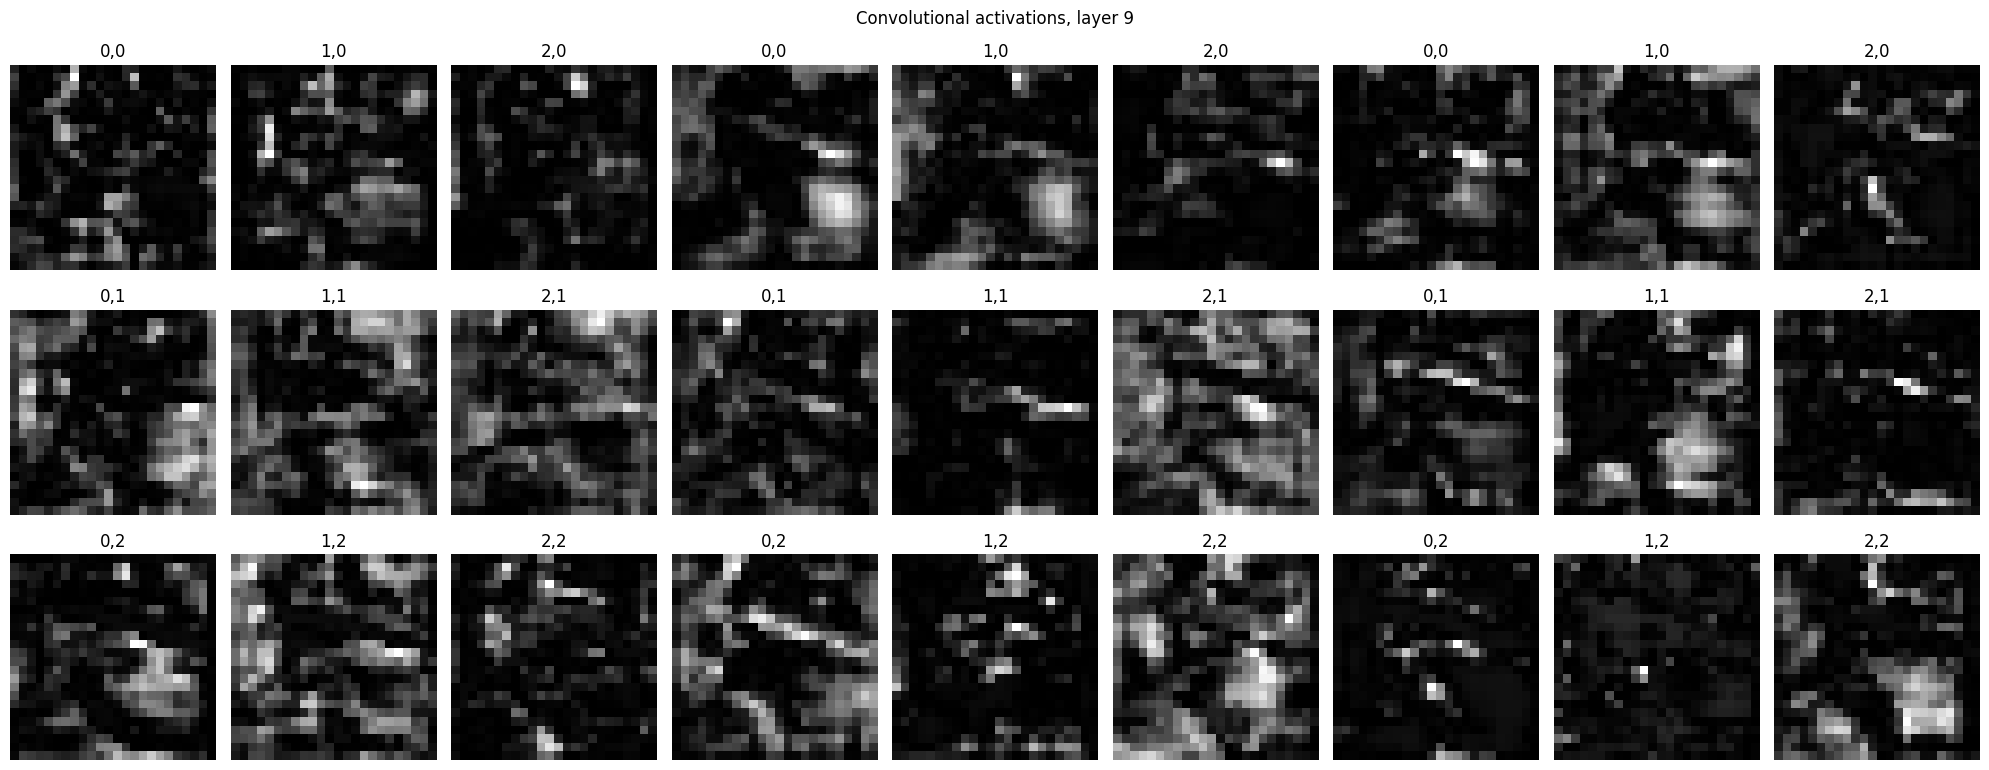

<Figure size 640x480 with 0 Axes>

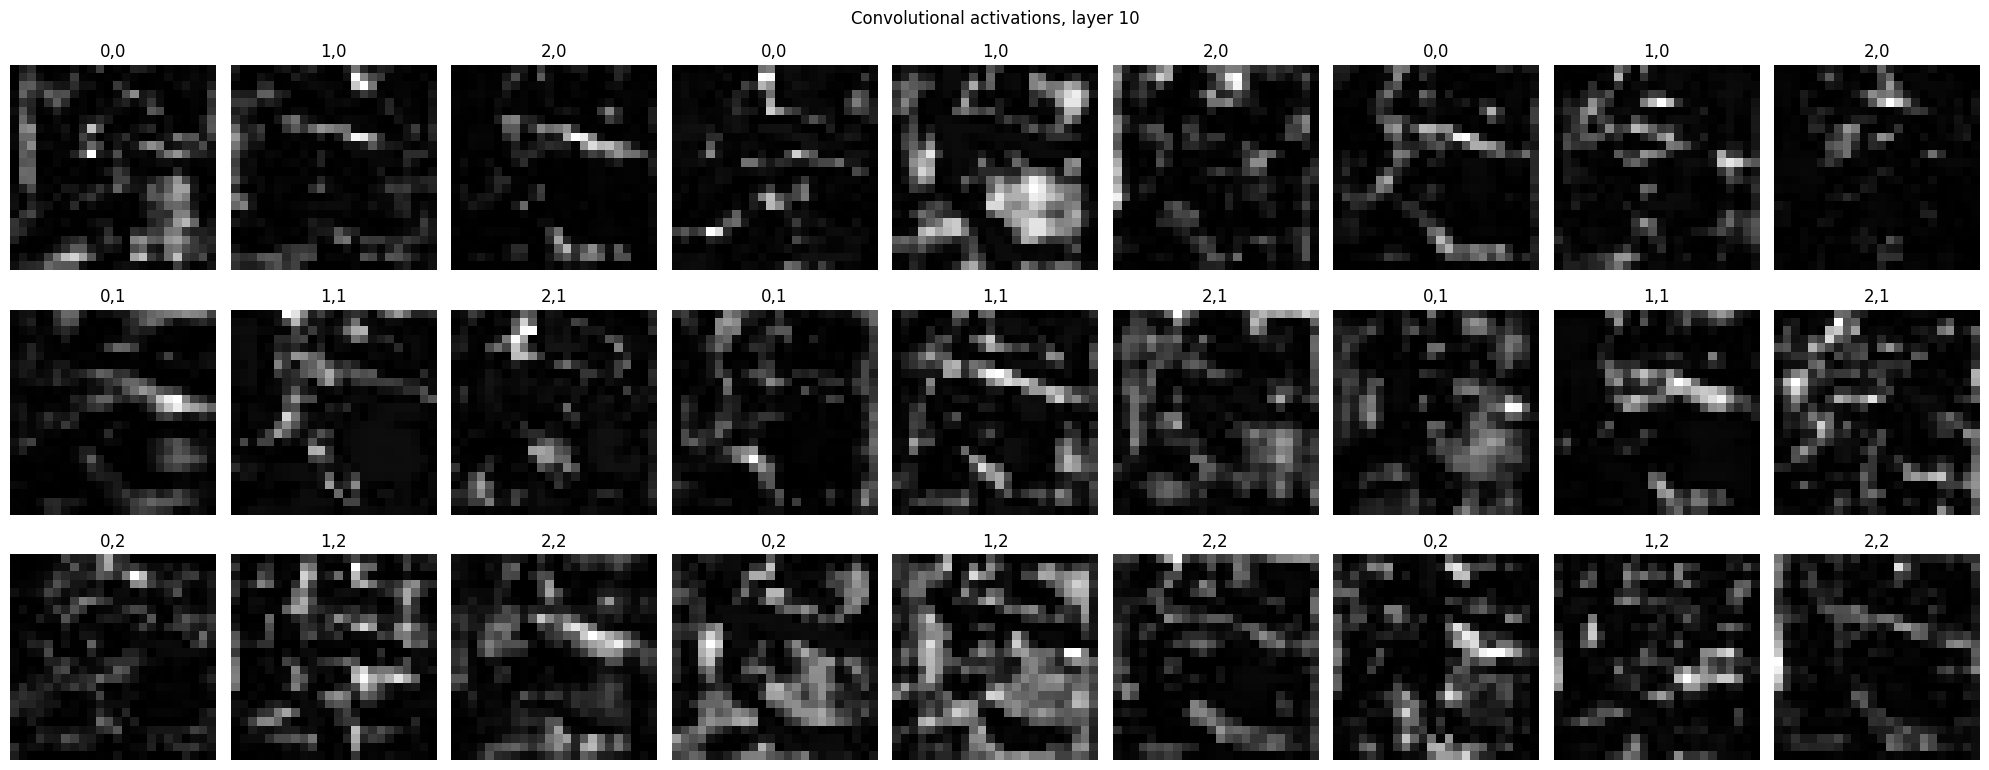

<Figure size 640x480 with 0 Axes>

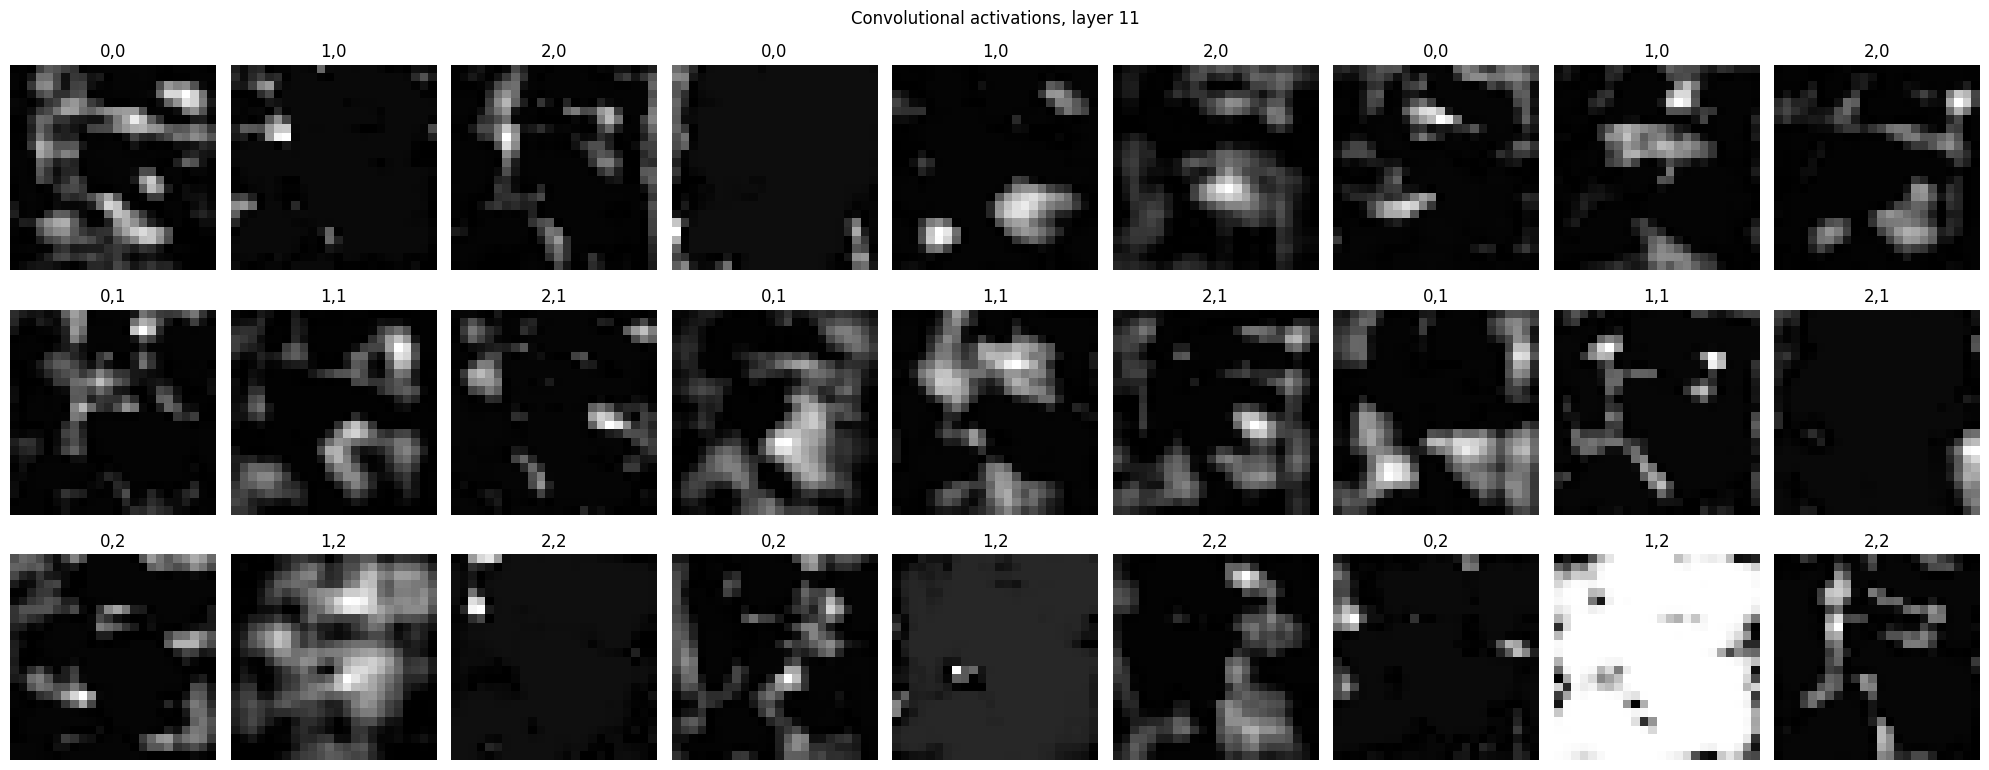

<Figure size 640x480 with 0 Axes>

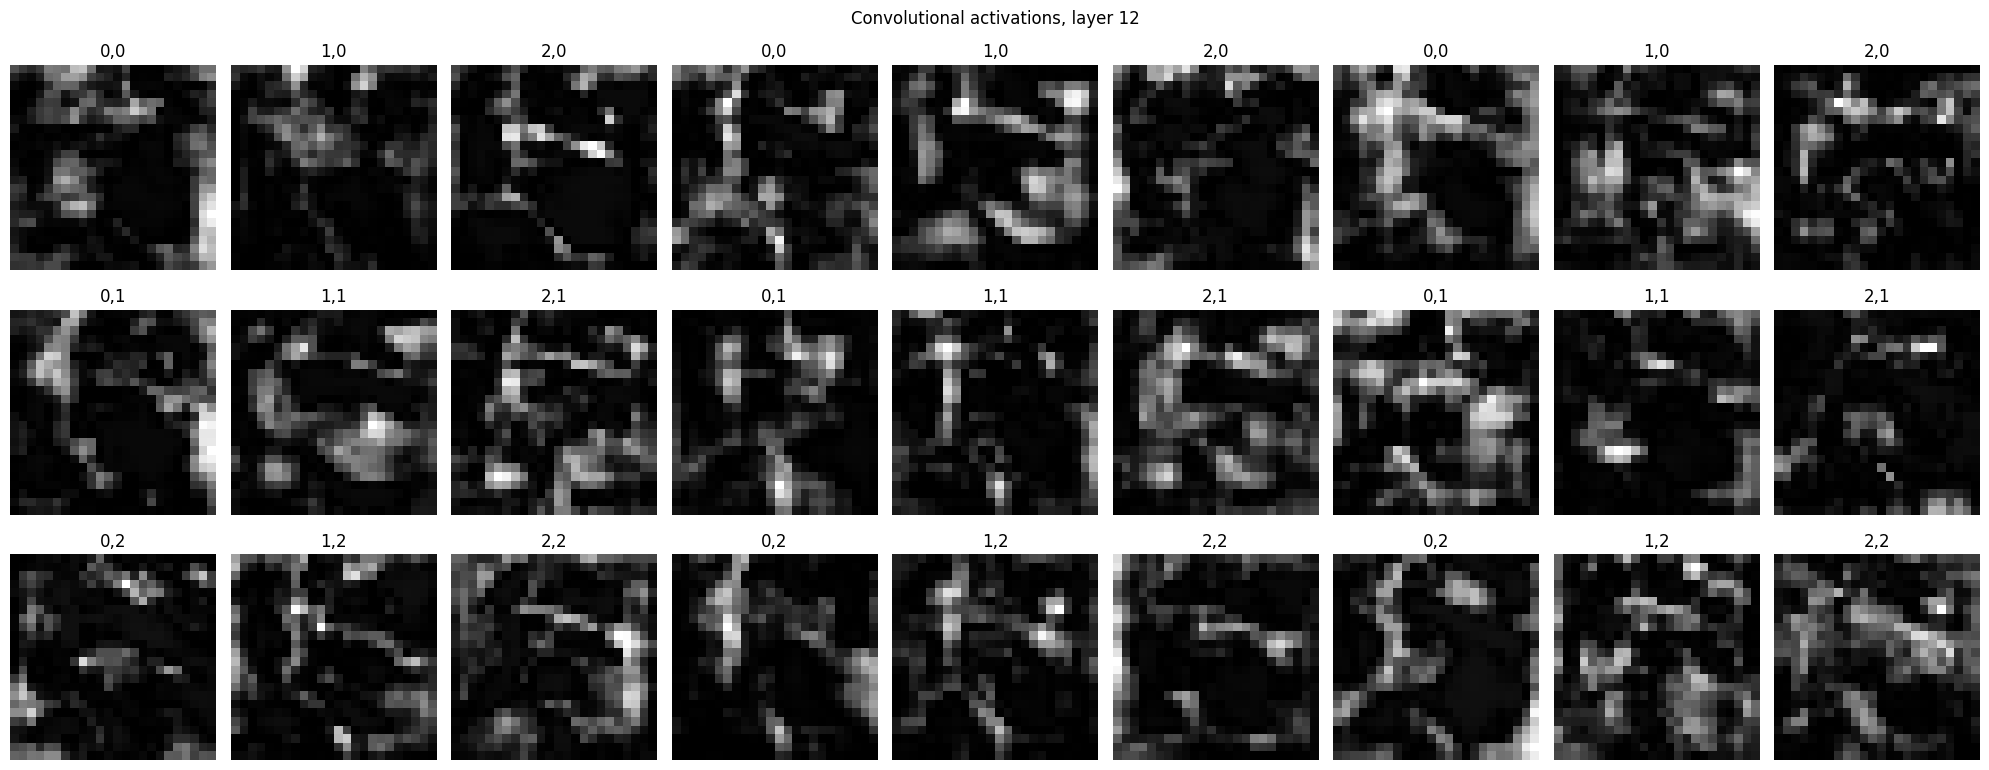

<Figure size 640x480 with 0 Axes>

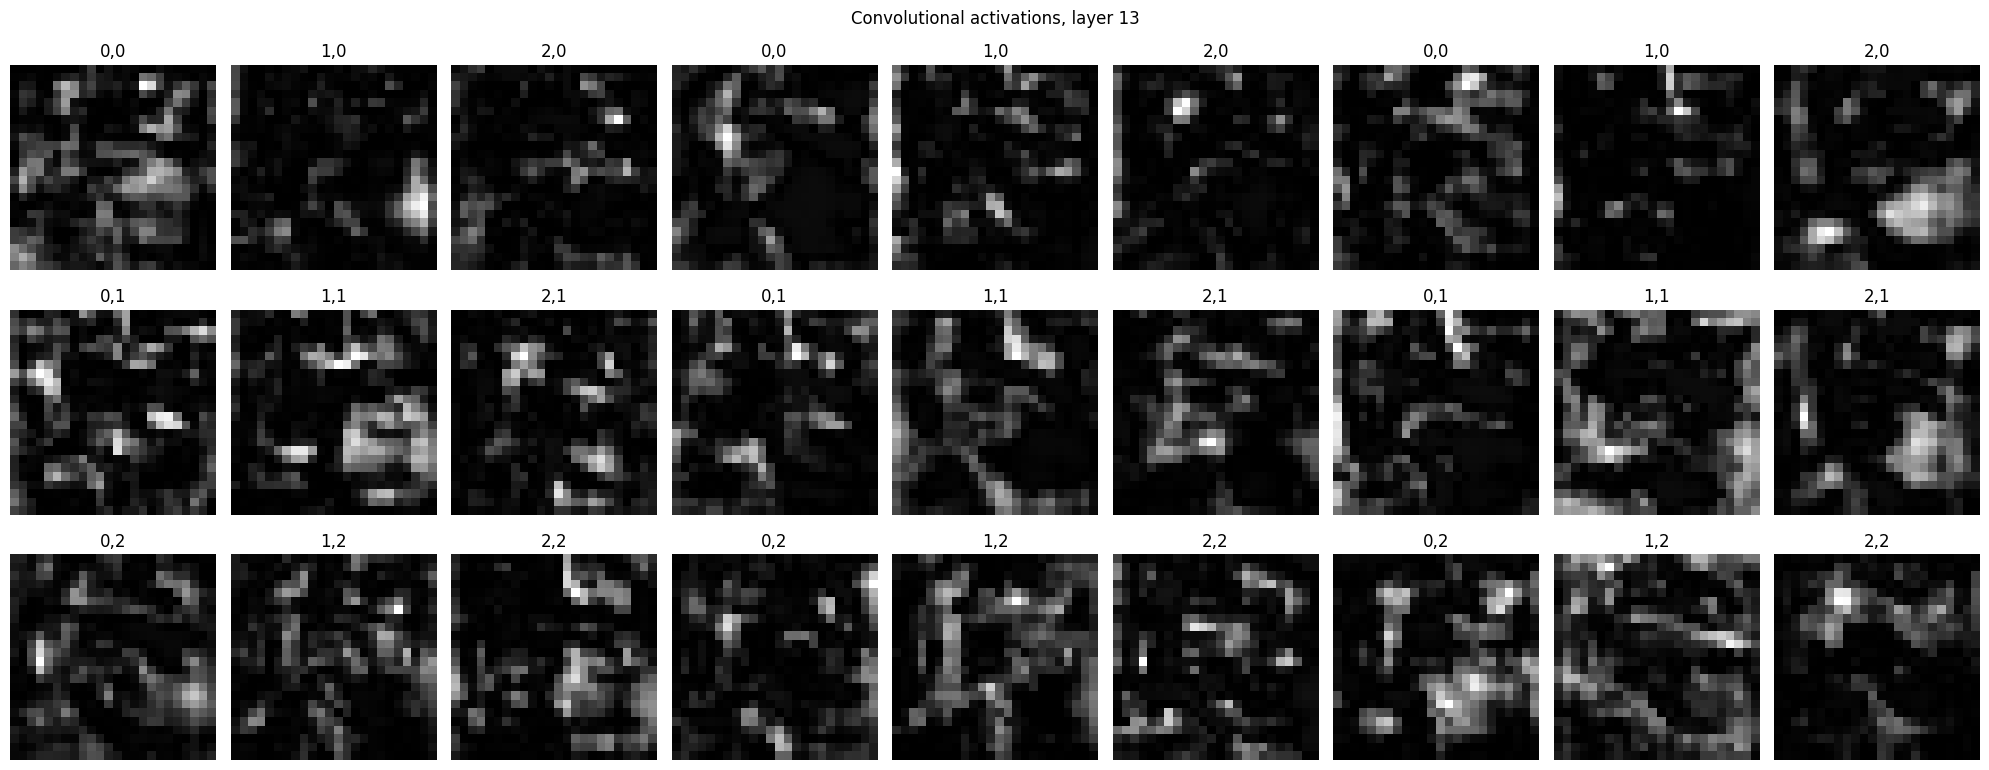

<Figure size 640x480 with 0 Axes>

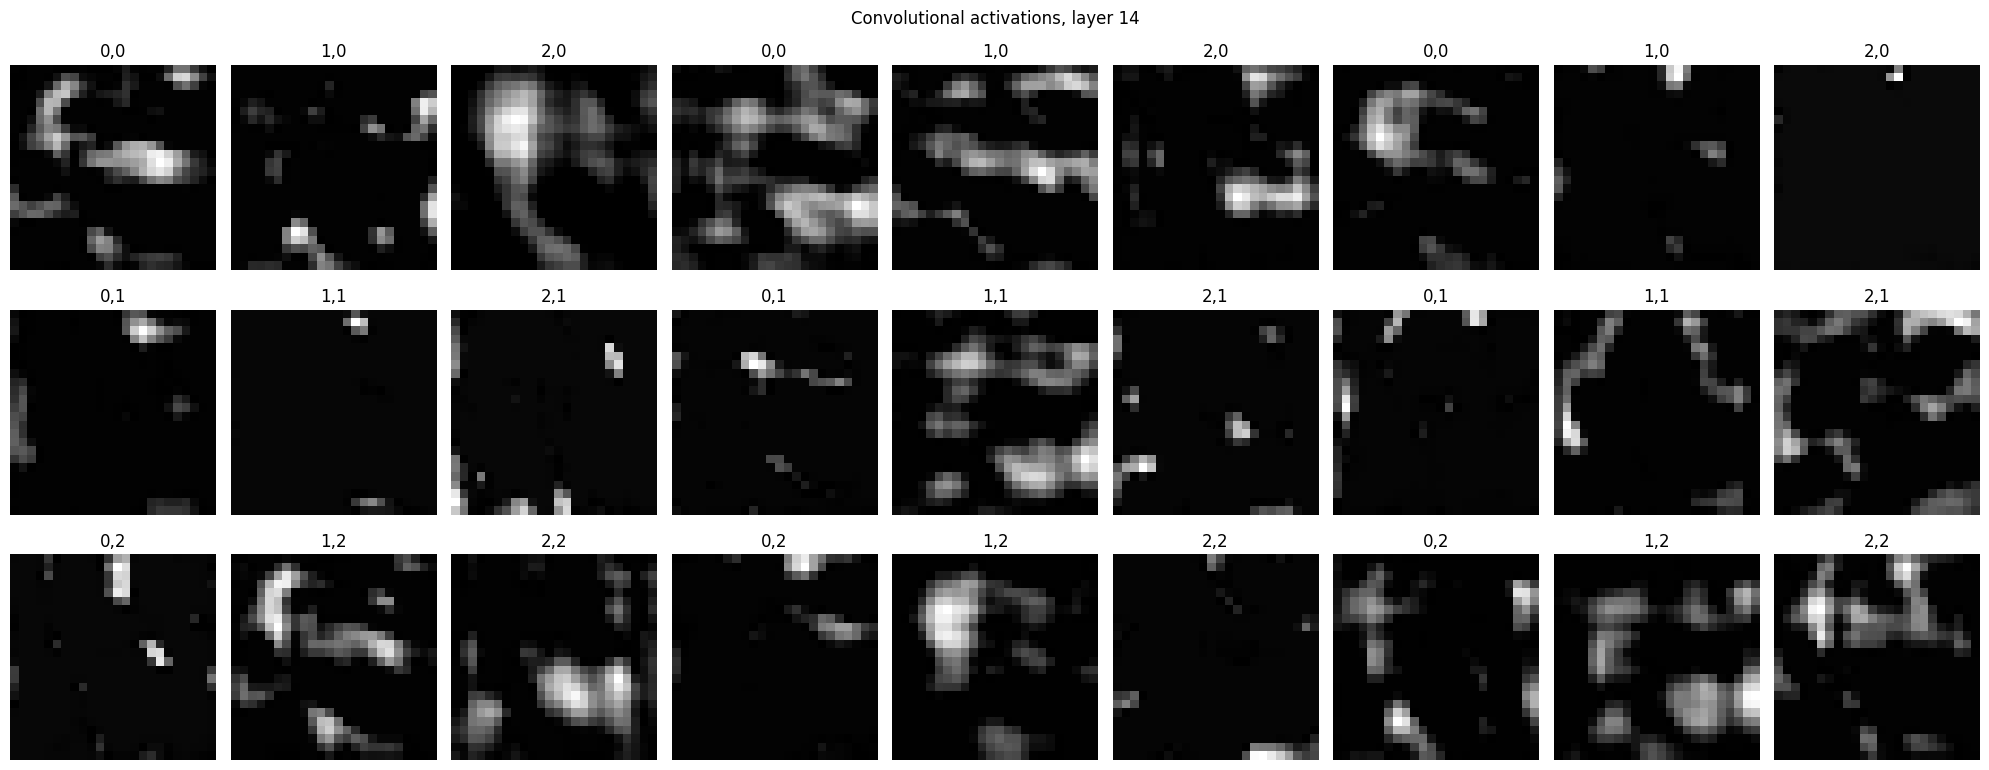

<Figure size 640x480 with 0 Axes>

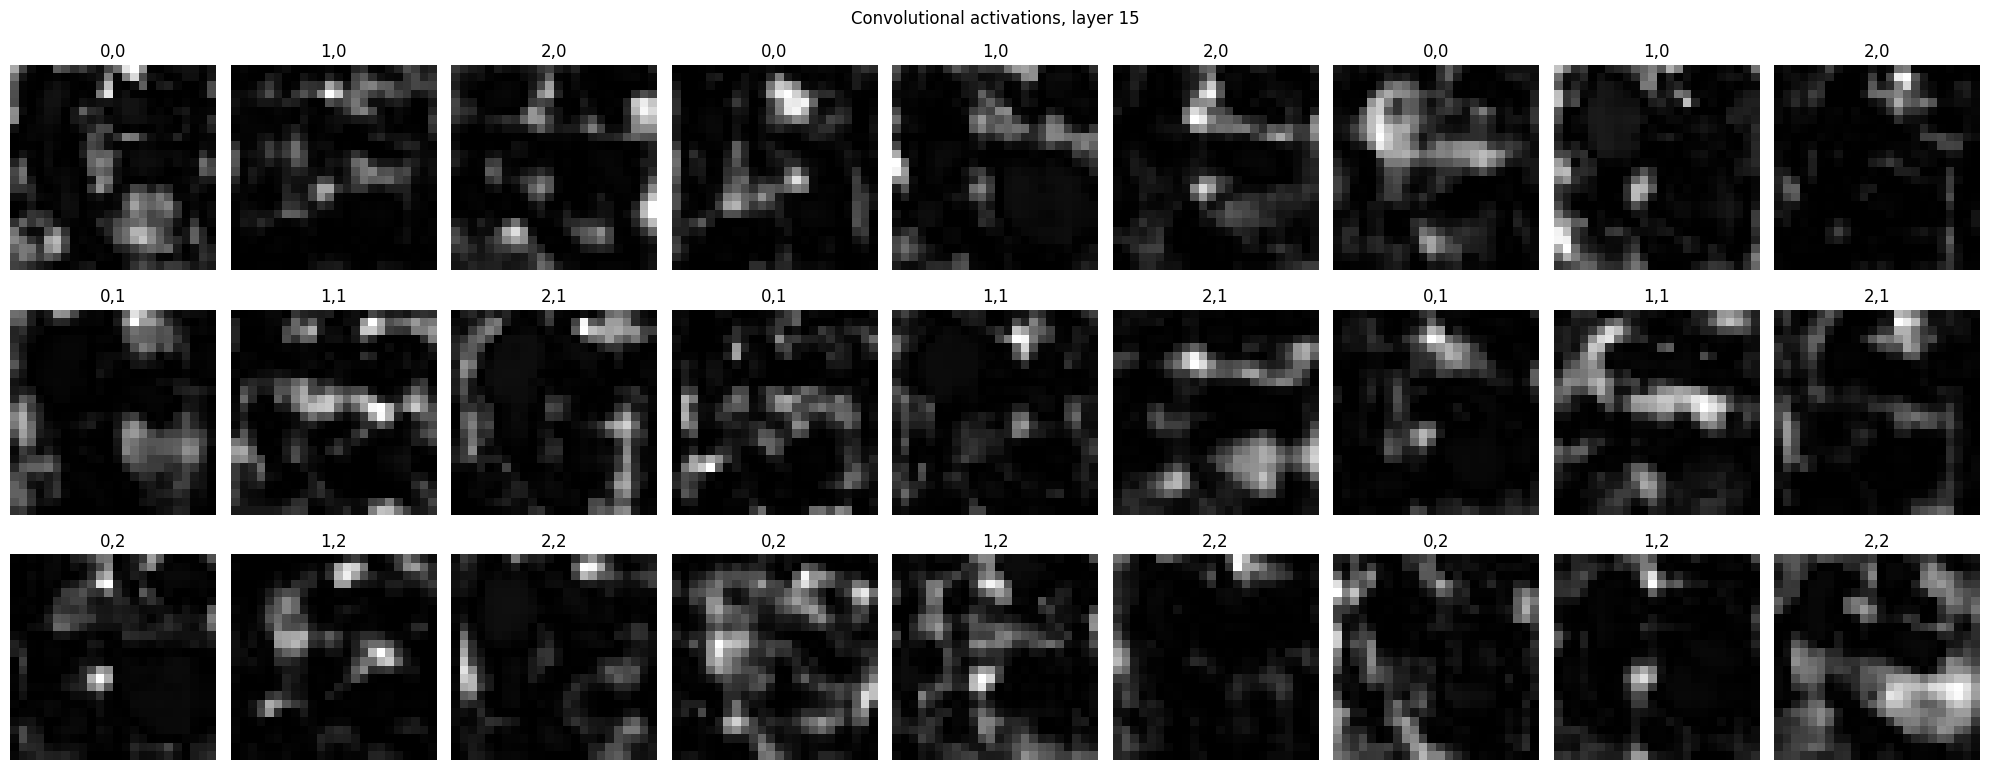

<Figure size 640x480 with 0 Axes>

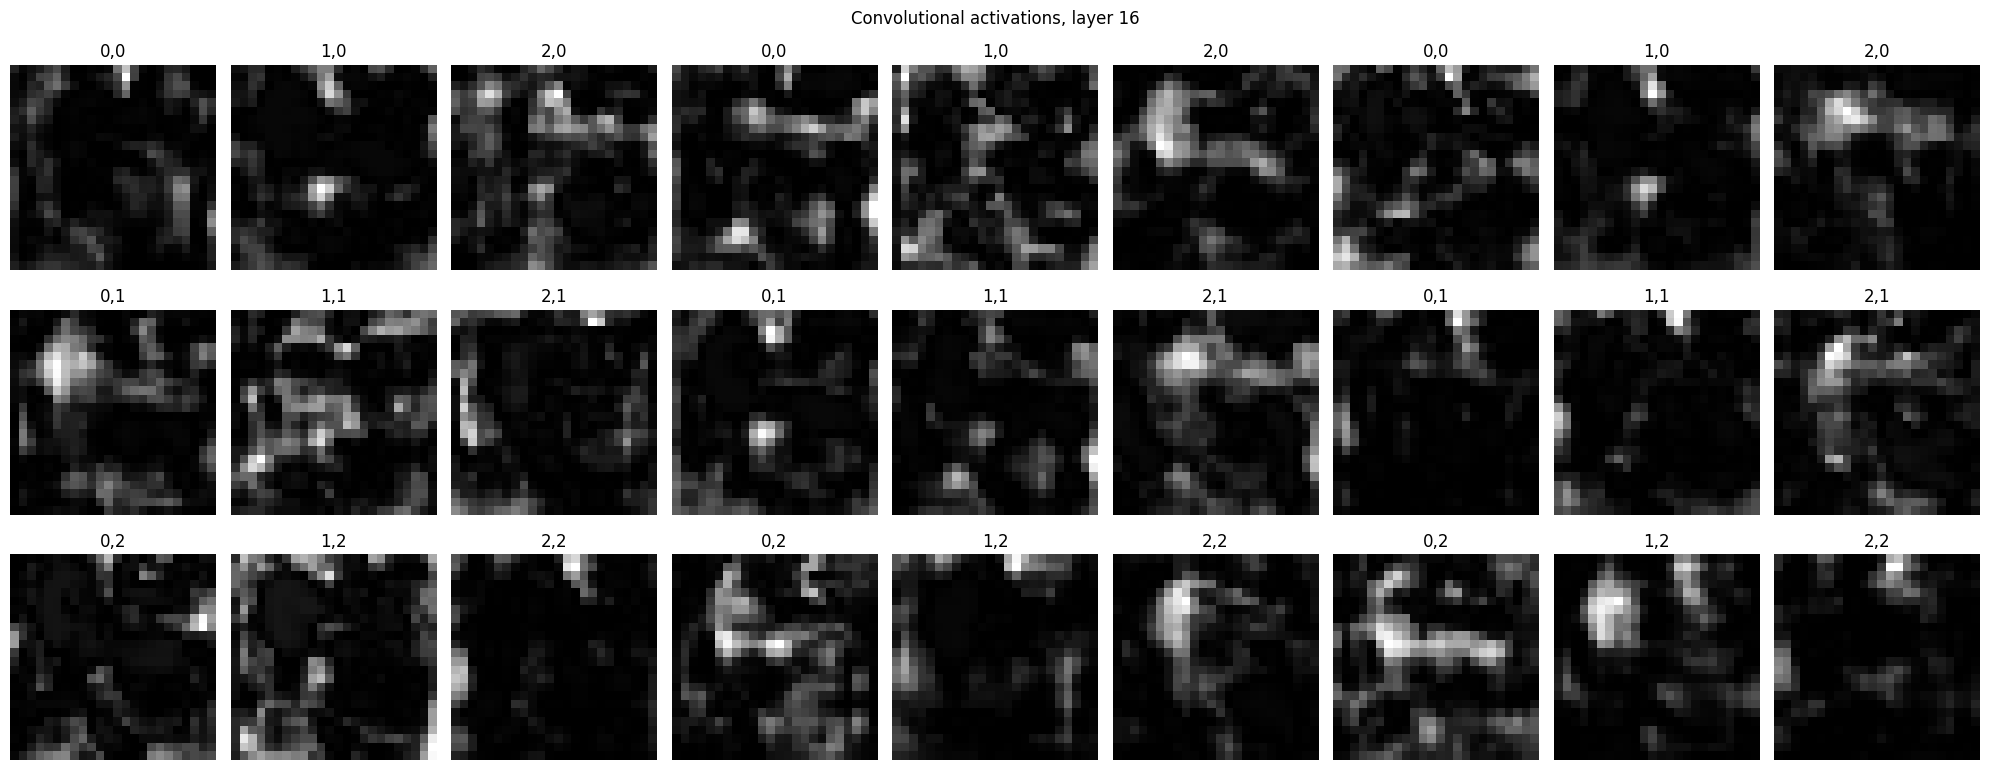

<Figure size 640x480 with 0 Axes>

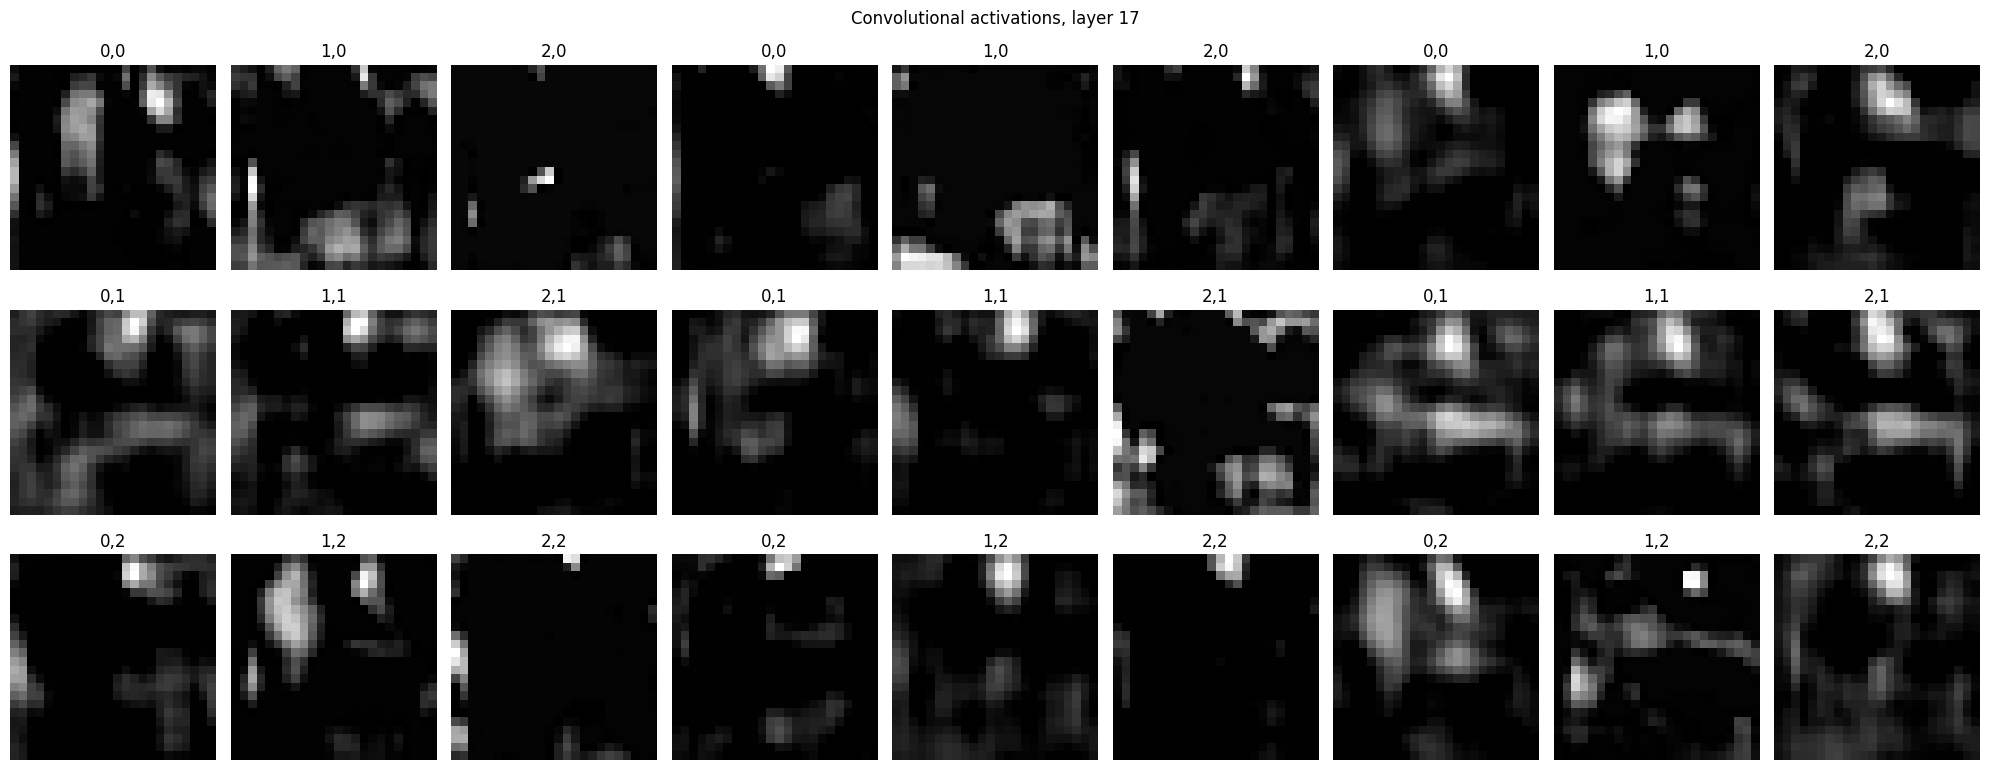

<Figure size 640x480 with 0 Axes>

In [ ]:
idx = 0

#templst = [convolution_filters[0]]

for _idx in range(layerLocs.__len__()) :
    nf = activations[_idx].shape[-1]
    if(nf == 3) :
        num_cols = 3
        num_rows = 1

    # Create subplots for displaying items
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))
        fig.suptitle('Convolutional activations, layer ' + str(idx))
        for i in range(nf):
            ax = axes[i]
            ax.imshow(activations[idx][image, :, :, i],cmap='gray')
            ax.title.set_text(str(i%num_rows) + "," + str(i//num_cols))
            ax.axis('off')
        plt.tight_layout()

    else:
        num_cols = int(nf/3)
        num_rows = int(nf/num_cols)

        # Create subplots for displaying items
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))
        fig.suptitle('Convolutional activations, layer ' + str(idx))
        for i in range(nf):
            ax = axes[i//(nf//num_rows), i%num_cols]
            ax.imshow(activations[idx][image, :, :, i],cmap='gray')
            ax.title.set_text(str(i%num_rows) + "," + str(i//num_cols))
            ax.axis('off')
        plt.tight_layout()

    idx += 1
    plt.show()
    plt.savefig("convolutional_activations_layer" + str(idx) + ".png")
